In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from time import time 
from tqdm.notebook import trange, tqdm

## Gillespie's method for the Ornstein-Uhlenbeck process

The SDE describing the Ornstein-Uhlenbeck process, in the notation used by Gillespie (1996), is

$$ \mathrm{d}X_t = -X_t \frac{1}{\tau} \, \mathrm{d}t + \sqrt{c} \, \mathrm{d}W_t. $$

Note that this is the same equation that we used to describe the random flight, only with different notation. We wrote:

\begin{align}
    \mathrm{d} x_t &= v_t \, \mathrm{d} t, \\
    \mathrm{d} v_t &= - \frac{1}{\tau}v_t \; \mathrm{d} t +  \sqrt{\frac{2\sigma^2}{\tau}} \, \mathrm{d} W_t.
\end{align}

Here, $v_t$ (representing the velocity of a particle) is the Ornstein-Uhlenbeck process, while $x_t$ (representing the position of a particle) is the integral of the Ornstein-Uhlenbeck process, since

$$x_t = x_0 + \int_0^t v_s \, \mathrm{d}s.$$

### Task a

Solve the two coupled SDEs for random flight for a large number of realisations. Compare to analytical distribution for the Ornstein-Uhlenbeck process. Check what happens when $\Delta t > \tau$.

The analytical expression for the distribution of the Ornstein-Uhlenbeck process (with the notation used in the random flight equation), starting from an initial distribution $\delta(v_0)$ at $t=0$ is a Gaussian with mean $v_0 \mathrm{e}^{-t/\tau}$ and variance $\frac{\sigma^2}{\tau^2}\big( 1 - \mathrm{e}^{-2t/\tau}\big)$.



In [35]:
# Analytical expression
def p(v, t, v0, tau, sigma):
    mean = v0 * np.exp(-t/tau)
    var  = sigma**2 * (1 - np.exp(-2*t/tau))
    return np.exp(-(v - mean)**2 / (2*var)) / (np.sqrt(2*np.pi*var))

In [2]:
# The Euler-Maruyama method
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dta
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

# A solver wrapper that can take a boundary handling function
# as an extra argument
def solve_SDE(X0, tmax, dt, a, b, solver, progressbar=True):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    if progressbar:
        iterator = trange
    else:
        iterator = range
    for n in iterator(1, Nt):
        # Call solver
        X[n,:] = solver(X[n-1,:], t, dt, a, b)
        t += dt
    return X

In [67]:
# Define sigma and tau
sigma = 0.25
tau   = 0.5

# Implementing the functions a and b
def a(X, t):
    # Assuming that X has shape (2, Np), where:
    # X[0,:] = x is position
    # X[1,:] = v is velocity
    a_ = np.array([
        X[1,:], # dx = v dt
        -(1/tau)*X[1,:],
    ])
    return a_

def b(X, t):
    # Assuming that X has shape (2, Np), where:
    # X[0,:] = x is position
    # X[1,:] = v is velocity
    b_ = np.zeros(X.shape)
    b_[1,:] = np.sqrt(2*sigma**2/tau)
    return b_


Np = 1000000
Tmax = 2
dt = 0.01
v0 = 0

X0 = np.zeros((2, Np))
X0[1,:] = v0

X = solve_SDE(X0, Tmax, dt, a, b, EM)

  0%|          | 0/200 [00:00<?, ?it/s]

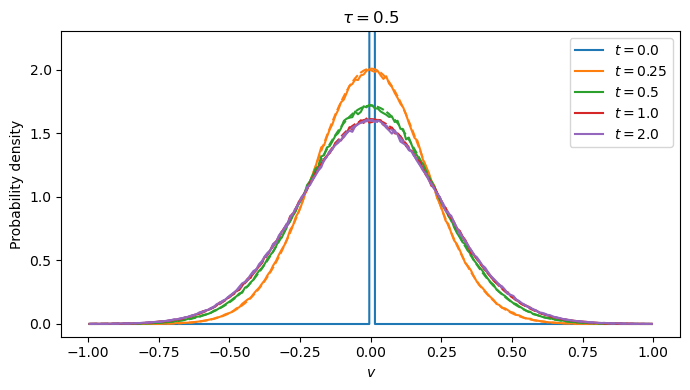

In [68]:
times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(-1, 1, 201, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the distribution of the velocities
fig = plt.figure(figsize=(7,4))

for t in [0, 0.25, 0.5, 1, 2]:
    it = np.argmin(np.abs(t - times))
    h, _ = np.histogram(X[it,1,:], bins=bins, density=True)
    l, = plt.plot(mids, h, label=f'$t={it*dt}$')
    
    if it > 0:
        plt.plot(mids, p(mids, it*dt, v0, tau, sigma), '--', c=l.get_color())
    
plt.legend()
plt.xlabel('$v$')
plt.ylabel('Probability density')
plt.ylim(-0.1, 2.3)
plt.title(f'$\\tau = {tau}$')
plt.tight_layout()

### Task b

Implement the Gillespie method, as described in Gillespie (1996).

In [90]:
def gillespie(X, Y, t, dt, c, tau):
    n1 = np.random.normal(loc=0, scale=1, size=len(X))
    n2 = np.random.normal(loc=0, scale=1, size=len(X))
    mu = np.exp(-dt/tau)
    sigma_x = np.sqrt( (c*tau/2) * (1 - mu**2) )
    sigma_y = np.sqrt(c*tau**3 * (dt/tau - 2*(1-mu) + (1-mu**2)/2))
    kappa_xy = (c*tau**2/2) * (1 - mu)**2
    X_ = X * mu + sigma_x * n1
    Y_ = Y + X*tau*(1-mu) + np.sqrt(sigma_y**2 - kappa_xy**2 / sigma_x**2)*n2 + kappa_xy*n1/sigma_x
    return X_, Y_

def solve_gillespie(X0, Y0, dt, tmax, c, tau):
    Nt = int(tmax/dt) + 1
    X = np.zeros((Nt, len(X0)))
    Y = np.zeros((Nt, len(Y0)))
    X[0,:] = X0
    Y[0,:] = Y0
    t = 0
    for i in trange(1, Nt):
        X[i,:], Y[i,:] = gillespie(X[i-1,:], Y[i-1,:], t, dt, c, tau)
        t += dt
    return X, Y

In [94]:
# Define sigma and tau
sigma = 0.25
tau   = 0.5
# tau is the same in Gillespie's notation, but calculate c
c = 2*sigma**2/tau


Np = 1000000
Tmax = 2
dt = 0.25
v0 = 0

X0 = v0 * np.ones(Np)
Y0 = np.zeros(Np)

X, Y = solve_gillespie(X0, Y0, dt, Tmax, c, tau)

  0%|          | 0/8 [00:00<?, ?it/s]

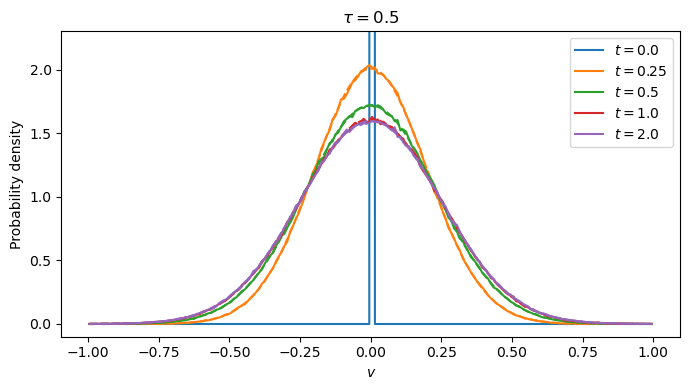

In [95]:
times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(-1, 1, 201, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the distribution of the velocities
fig = plt.figure(figsize=(7,4))

for t in [0, 0.25, 0.5, 1, 2]:
    it = np.argmin(np.abs(t - times))
    h, _ = np.histogram(X[it,:], bins=bins, density=True)
    l, = plt.plot(mids, h, label=f'$t={it*dt}$')
    
    if it > 0:
        plt.plot(mids, p(mids, it*dt, v0, tau, sigma), '--', c=l.get_color())
    
plt.legend()
plt.xlabel('$v$')
plt.ylabel('Probability density')
plt.ylim(-0.1, 2.3)
plt.title(f'$\\tau = {tau}$')
plt.tight_layout()

In [122]:
# Define sigma and tau
sigma = 0.25
tau   = 1
# tau is the same in Gillespie's notation, but calculate c
c = 2*sigma**2/tau


Np = 1
Tmax = 10
dt = 0.01
v0 = 0

X0 = v0 * np.ones(Np)
Y0 = np.zeros(Np)

X, Y = solve_gillespie(X0, Y0, dt, Tmax, c, tau)

# Create realisation by just drawing from theoretical distribution
Nt = len(X)
X_random = np.zeros(Nt)
for i in range(Nt):
    t = i*dt
    mean = v0 * np.exp(-t/tau)
    var  = sigma**2 * (1 - np.exp(-2*t/tau))
    X_random[i] = np.random.normal(loc=mean, scale=np.sqrt(var))

  0%|          | 0/1000 [00:00<?, ?it/s]

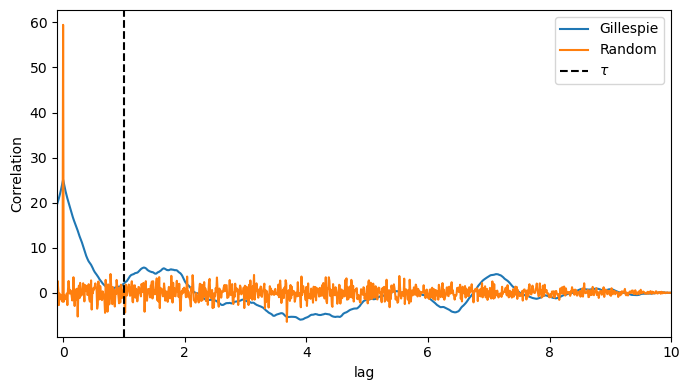

In [126]:
fig = plt.figure(figsize=(7,4))

corr = np.correlate(X[:,0], X[:,0], mode='full')
lag = np.linspace(-Tmax, Tmax, len(corr))
plt.plot(lag, corr, label='Gillespie')

corr = np.correlate(X_random, X_random, mode='full')
plt.plot(lag, corr, label='Random')

ylim = plt.ylim()
plt.plot([tau, tau], ylim, '--', c='k', label='$\\tau$')
plt.legend()
plt.xlim(-0.1, Tmax)
plt.ylim(*ylim)
plt.xlabel('lag')
plt.ylabel('Correlation')
plt.tight_layout()

In [99]:
corr

array([30.12134361])

## References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5